In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import models, initializers
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2025-05-05 16:28:37.481676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746462517.693198      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746462517.750724      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# Constants
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50
PATCH_SIZE = 4  # For MobileViT
patch_size=4
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
CLASS_NAMES = [
    'Ambassador', 'Autorickshaw', 'Bicycle', 'Bus', 'Car', 'MiniTruck', 'Motorized2wheeler', 'Motorvan', 'Rickshaw', 'Toto', 'Truck', 'Van'
]
NUM_CLASSES = len(CLASS_NAMES)

# Data paths
train_data_dir = "/kaggle/input/vehicle-cropped/train"
test_data_dir = "//kaggle/input/vehicle-cropped/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image data generator for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


# Data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Ensure predictions match labels during evaluation
)


Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.


In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC




def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = x
    #local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    #folded_feature_map = conv_block(
     #   folded_feature_map, filters=local_features.shape[-1], kernel_size=1, strides=strides
    #)
    local_global_features = layers.Concatenate(axis=-1)([local_features, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim,kernel_size=1, strides=strides
    )

    return local_global_features


base_model = MobileNetV2(weights='imagenet',input_shape=inputShape,include_top=False)
#base_model = MobileNetV2(weights=None,input_shape=inputShape,include_top=False)
base_model.trainable = True


def create_vit_classifier():
    inputs = layers.Input(shape=inputShape)
    # Augment data.
    MVx = base_model(inputs)
    #augmented = data_augmentation(inputs)
    x = mobilevit_block(MVx, num_blocks=1, projection_dim=64)

    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)

    #x = layers.Conv2D(5, 1, activation="softmax")(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.GlobalAvgPool2D()(x)
    #outputs = layers.Activation('softmax')(x)

    return keras.Model(inputs, outputs)


I0000 00:00:1746462687.783401      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
modelv2cw = create_vit_classifier()
modelv2cw.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
modelv2cw.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_128      │ (None, 4, 4, 1280)     │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 4, 4, 64)       │         81,984 │ mobilenetv2_1.00_128[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 4, 4, 64)       │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 4, 4, 64)       │            128 │ reshape[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 4, 4, 64)       │         33,216 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 4, 4, 64)       │              0 │ multi_head_attention[… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 4, 4, 64)       │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4, 4, 128)      │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 4, 4, 128)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4, 4, 64)       │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4, 4, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 4, 4, 64)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 4, 4, 64)       │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 4, 128)      │              0 │ conv2d[0][0],          │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)    

 Total params: 2,399,052 (9.15 MB)

 Trainable params: 2,364,940 (9.02 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
from sklearn.utils import class_weight

# Calculate class weights
class_labels = train_generator.classes  # Get the class labels from the generator
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(class_labels), 
    y=class_labels
)

class_weight_dict = dict(zip(np.unique(class_labels), class_weights))

In [9]:
y_train = train_generator.classes
cw=class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
cw

array([ 0.65939824,  0.70516992,  3.01003086,  0.58785413,  0.69019816,
        1.84706439,  0.67584893, 12.50320513,  0.67584893,  8.33547009,
        2.7549435 ,  0.65806343])

In [10]:
from sklearn.utils import class_weight
import numpy as np

# Assuming train_generator.classes is available with your dataset
class_labels = train_generator.classes  # Get the class labels from the generator

# Calculate class weights
"""
class_weights = class_weight.compute_class_weight(
    'balanced',  # Use 'balanced' to calculate weights based on frequency
    classes=np.unique(class_labels),  # Unique classes
    y=class_labels  # Labels for each sample
)

class_weights = [
    0.6483631, 2.59345238, 0.64376478, 10.08564815, 1.9840619307832423, 
    0.6483630952380952, 3.0256944444444445, 0.7564236111111111, 
    0.6483630952380952, 0.6483630952380952, 0.6472073677956031, 
    11.002525252525253
]
"""
# Create a dictionary of class labels with their corresponding weights
class_weight_dict = dict(zip(np.unique(class_labels), cw))

# Print the class weights
print("Class Weights:")
for class_idx, class_weight in class_weight_dict.items():
    print(f"Class: {CLASS_NAMES[class_idx]}, Weight: {class_weight}")

Class Weights:
Class: Ambassador, Weight: 0.6593982420554428
Class: Autorickshaw, Weight: 0.7051699204627621
Class: Bicycle, Weight: 3.010030864197531
Class: Bus, Weight: 0.5878541289933695
Class: Car, Weight: 0.6901981599433828
Class: MiniTruck, Weight: 1.847064393939394
Class: Motorized2wheeler, Weight: 0.6758489258489259
Class: Motorvan, Weight: 12.503205128205128
Class: Rickshaw, Weight: 0.6758489258489259
Class: Toto, Weight: 8.335470085470085
Class: Truck, Weight: 2.7549435028248586
Class: Van, Weight: 0.6580634278002699


In [11]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',  # Change this to end with .keras
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


In [12]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)

# Train the model with class weights
history = modelv2cw.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746462764.229877     107 service.cc:148] XLA service 0x7c0640002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746462764.230724     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746462768.053979     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746462774.049384     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746462774.250511     107 gpu_timer.cc:

  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:09:26 64s/step - accuracy: 0.1250 - loss: 3.7990

I0000 00:00:1746462787.398721     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/122 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.5554 - loss: 1.5669

E0000 00:00:1746462824.441918     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746462824.645259     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


122/122 ━━━━━━━━━━━━━━━━━━━━ 132s 564ms/step - accuracy: 0.5686 - loss: 1.5279 - val_accuracy: 0.1534 - val_loss: 5.5981 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.7824 - loss: 0.8054 - val_accuracy: 0.3847 - val_loss: 2.8226 - learning_rate: 0.0010
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.7775 - loss: 0.7957 - val_accuracy: 0.3394 - val_loss: 4.0367 - learning_rate: 0.0010
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8091 - loss: 0.5921 - val_accuracy: 0.2993 - val_loss: 3.4237 - learning_rate: 0.0010
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.8314 - loss: 0.5458 - val_accuracy: 0.2192 - val_loss: 5.2272 - learning_rate: 0.0010
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.8222 - loss: 0.6009 - val_accuracy: 0.3054 - val_loss: 3.1385 - learning_rate: 0.0010
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.8499 - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step


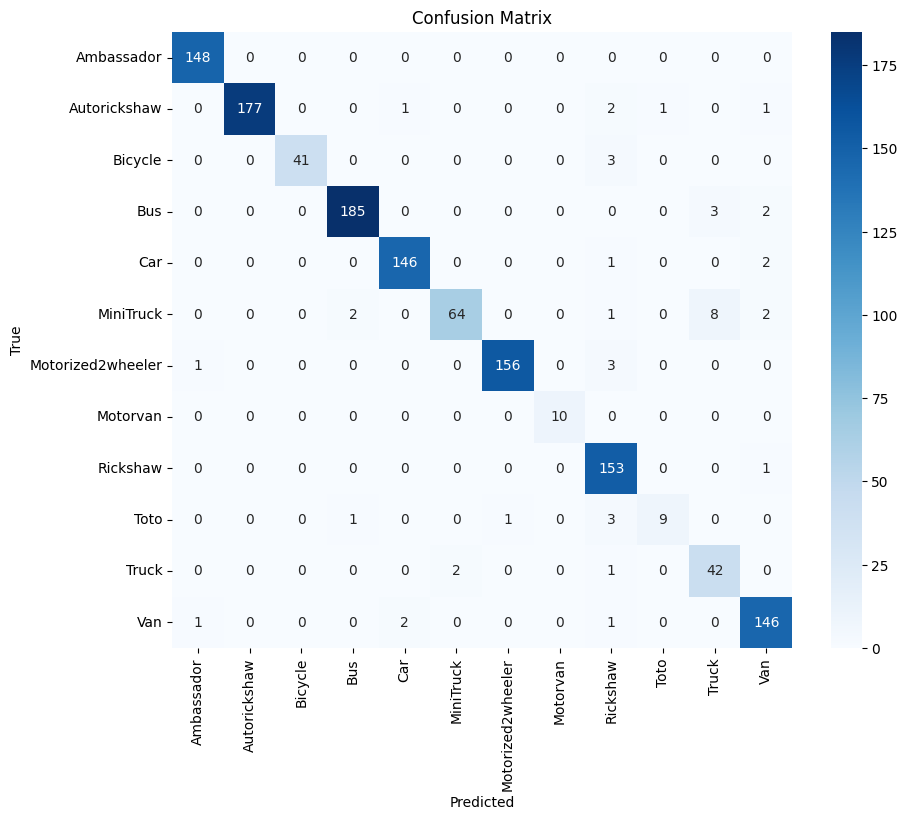

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the predictions are done after your model evaluation
y_true = test_generator.classes  # True labels from the test set
y_pred = np.argmax(modelv2cw.predict(test_generator), axis=-1)  # Predicted labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize it with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


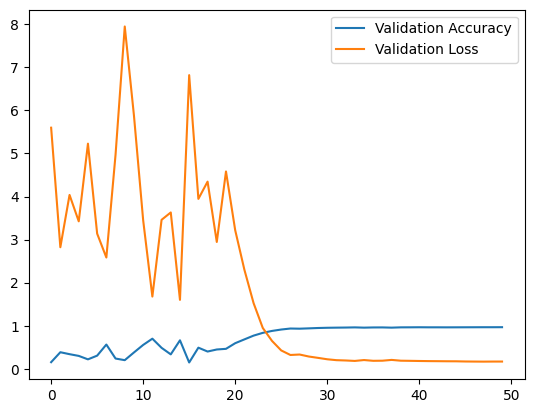

In [14]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()


In [15]:
# Evaluate the model
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

start_time = time.time()
test_loss, test_accuracy = modelv2cw.evaluate(test_generator)
evaluation_time = time.time() - start_time
print(f"Evaluation Time: {evaluation_time:.2f} seconds")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions and metrics
y_true = test_generator.classes
y_pred = np.argmax(modelv2cw.predict(test_generator), axis=-1)

# Overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='weighted')
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_f1_score = f1_score(y_true, y_pred, average='weighted')

print("\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.2f}")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1 Score: {overall_f1_score:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9754 - loss: 0.1119
Evaluation Time: 5.29 seconds
Test Loss: 0.166364386677742, Test Accuracy: 0.9652305245399475
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step

Overall Metrics:
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      1.00      0.99       148
     Autorickshaw       1.00      0.97      0.99       182
          Bicycle       1.00      0.93      0.96        44
              Bus       0.98      0.97      0.98       190
              Car       0.98      0.98      0.98       149
        MiniTruck       0.97      0.83      0.90        77
Motorized2wheeler       0.99      0.97      0.98       160
         Motorvan       1.00      1.00      1.00        10
         Rickshaw       0.91      0.99      0.95       154
             Toto       0.90      0.64      0.75        14
            Truck       0.79      0.93  